# BuzzFeed Headline Exploratory Data Analysis

In this notebook we're going to explore what exactly makes a BuzzFeed headline and the tricks they use to grab your attention.

In [164]:
import pandas as pd
import numpy as np
import matplotlib
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# matplotlib.style.use('fivethirtyeight')
sns.set_style('ticks')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

colors = ['#006ba6', '#0496ff', '#ffbc42', '#d81159', '#8f2d56', '#41ead4', '#ff206e']
sns.color_palette(colors)
sns.set_palette(colors)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect
from wordcloud import WordCloud
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

stop_words = stopwords.words('english')

%config InlineBackend.figure_format = 'retina'
pd.set_option("display.max_rows", None)


print('Setup Complete.')

Setup Complete.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [165]:
data = pd.read_csv('../data/buzzfeed_headlines.csv')
print(data.shape)

# let's shuffle the dataset so everything is mixed together appropriately

data = data.sample(frac=1).reset_index().drop('index', axis=1)
data.head()

(380, 3)


,content,description,title
0,The seat-back pocket on a plane is great and a...,"Under $50- home decor, clothing items, organiz...",35 Affordable Things That'll Make You Feel Oh-...
1,Get all the best moments in pop culture &amp; ...,You win or you die.View Entire Post ›,"How Would You Die On ""Game Of Thrones?"""
2,Keep up with the latest daily buzz with the Bu...,Yippee-ki-yay!View Entire Post ›,Harry And Sally? John McLaine And Holly? This ...
3,He literally barked like a dog in the middle o...,He literally barked like a dog in the middle o...,25 Times Harry Styles Went Out Of His Way To M...
4,Joe was back in full force last Friday.,Joe was back in full force last Friday.View En...,Penn Badgley Weighed In On The Wild Finale Of ...


## Exploring our Text Analytics

Diving into the bits'n'pieces of the format the headlines are in and what they're comprised of.

For simpler pre-processing, we'll convert the `title` column text into lowercase first.

In [166]:
def lower_title(text):
    text = str(text).lower()
    return text

data['title'] = data['title'].apply(lower_title)

data.head()

,content,description,title
0,The seat-back pocket on a plane is great and a...,"Under $50- home decor, clothing items, organiz...",35 affordable things that'll make you feel oh-...
1,Get all the best moments in pop culture &amp; ...,You win or you die.View Entire Post ›,"how would you die on ""game of thrones?"""
2,Keep up with the latest daily buzz with the Bu...,Yippee-ki-yay!View Entire Post ›,harry and sally? john mclaine and holly? this ...
3,He literally barked like a dog in the middle o...,He literally barked like a dog in the middle o...,25 times harry styles went out of his way to m...
4,Joe was back in full force last Friday.,Joe was back in full force last Friday.View En...,penn badgley weighed in on the wild finale of ...


Let's see how long each title is, on a character-based level, and maybe what the average title length is:

In [167]:
data['title_len'] = data['title'].apply(len)
data.sample(4)

,content,description,title,title_len
346,"""Luckily in middle school, they had a very tho...","""Luckily in middle school, they had a very tho...",gwyneth paltrow revealed how she talks to her ...,84
12,"""They made a very convincing hot couple.""","""They made a very convincing hot couple.""View ...","shia labeouf was almost cast in ""call me by yo...",78
347,"It was ""really stressful.""","It was ""really stressful.""View Entire Post ›","amanda seyfried says she had a ""tough case of ...",104
360,"Many customers, when told there's a wait, will...","If the sign says ""Please wait to be seated,"" p...",if you do any of these 17 things when being se...,96


What do our simple stats for title length look like?

In [168]:
data['title_len'].describe()

count    380.000000
mean      87.871053
std       24.656836
min       31.000000
25%       69.000000
50%       86.000000
75%      104.000000
max      160.000000
Name: title_len, dtype: float64

Taking a look at what each title's length looks like, starting from the minimum length to the max.

In [169]:
data.groupby(['title_len'], as_index=False)['title'].max()

,title_len,title
0,31,【速報】hpvワクチン、積極的勧奨の再開を了承 厚労省の審議会
1,35,what's your nightmare period story?
2,38,トランスジェンダーは婦人科を受診しちゃいけないの？ 当事者や医師に聞いてみた
3,39,"how would you die on ""game of thrones?"""
4,42,these random questions reveal if you floss
5,43,自民党「影の幹事長」がdappiへの関与を否定。群馬の村で見えた“親族のつながり“とは
6,47,17 actors who i'm convinced could play any role
7,48,rate these creamy foods and we'll guess your age
8,49,36 products that might help solve your sleep woes
9,50,these 90s rom-coms will 100% make your life be...


We should probably remove the 3 titles that aren't English, just for the sake of consistency of our values that we'll eventually be processing and putting into our ML model. We'll make use of the handy library `langdetect` to easily detect and extract which headlines aren't in English.

In [170]:
def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return np.nan
    
data['language'] = data.title.apply(detect_lang)

In [171]:
data = data[data.language == "en"]
data.groupby(['title_len'], as_index=False)['title'].max()

,title_len,title
0,35,what's your nightmare period story?
1,38,just 34 very nice things for your home
2,39,"how would you die on ""game of thrones?"""
3,42,these random questions reveal if you floss
4,47,17 actors who i'm convinced could play any role
5,48,rate these creamy foods and we'll guess your age
6,49,36 products that might help solve your sleep woes
7,50,these 90s rom-coms will 100% make your life be...
8,51,these 20 high fashion dogs dress better than y...
9,52,what’s it like to have never been in a relatio...


Dropping our `language` column since it's not needed anymore.

In [172]:
data = data.drop('language', axis=1)

In [173]:
data.head()

,content,description,title,title_len
0,The seat-back pocket on a plane is great and a...,"Under $50- home decor, clothing items, organiz...",35 affordable things that'll make you feel oh-...,54
1,Get all the best moments in pop culture &amp; ...,You win or you die.View Entire Post ›,"how would you die on ""game of thrones?""",39
2,Keep up with the latest daily buzz with the Bu...,Yippee-ki-yay!View Entire Post ›,harry and sally? john mclaine and holly? this ...,101
3,He literally barked like a dog in the middle o...,He literally barked like a dog in the middle o...,25 times harry styles went out of his way to m...,98
4,Joe was back in full force last Friday.,Joe was back in full force last Friday.View En...,penn badgley weighed in on the wild finale of ...,106


Before cleaning our `title` column to be put into an ML pipeline, let's just do some basic text analytics to get a sense of what each title consists of.

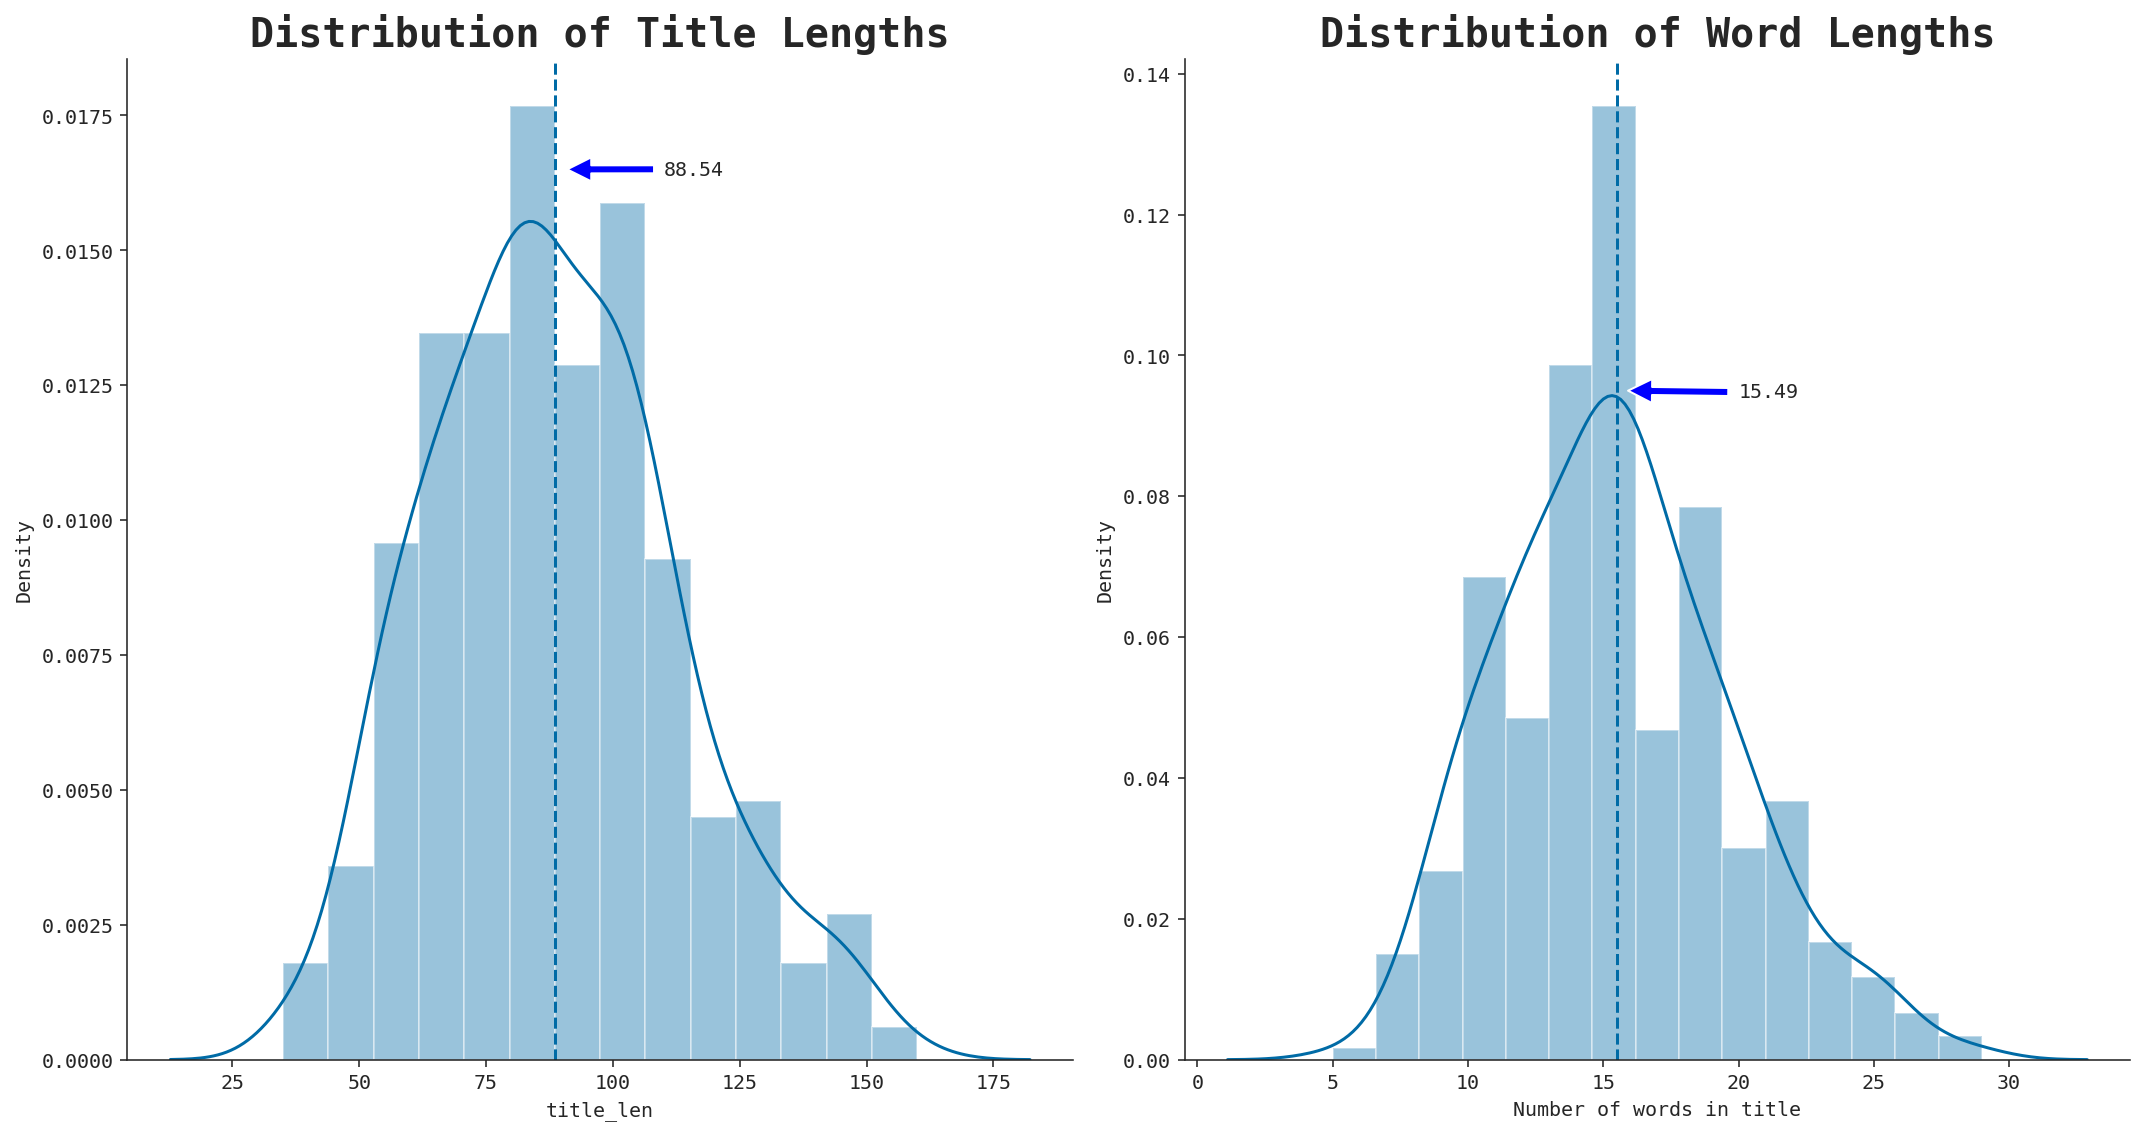

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.distplot(data['title_len']).set_title('Distribution of Title Lengths', fontsize=20, fontweight='bold')
plt.axvline(np.array(data['title_len'].mean()), ls='dashed')
plt.annotate(round(data['title_len'].mean(),2), xy=(90, 0.0165), xycoords='data', xytext=(110, 0.0164),
             arrowprops=dict(facecolor='blue', shrink=0.05))


title_word_len = data['title'].str.split().map(lambda x: len(x))
word_len_mean = round(title_word_len.mean(), 2)

plt.subplot(1, 2, 2)
sns.distplot(title_word_len).set_title('Distribution of Word Lengths', fontsize=20, fontweight='bold')
plt.axvline(word_len_mean, ls='dashed')
plt.annotate(word_len_mean, xy=(15.7, 0.095), xycoords='data', xytext=(20, 0.094),
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.xlabel("Number of words in title")

# ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
# ax.set_ylabel('')

plt.tight_layout()
plt.show();

In [175]:
min_title_words = data.title.str.split().map(lambda x: len(x)).min()
max_title_words = data.title.str.split().map(lambda x: len(x)).max()

print(f"The minimum amount of words in our titles is {min_title_words}")
print(f"The maxmimu amount of words in our titles is {max_title_words}")

The minimum amount of words in our titles is 5
The maxmimu amount of words in our titles is 29


If anyone has ever seen any sort of clickbait headlines (which BuzzFeed apparently denies their headlines are clickbait), they've most likely noticed it probably has an odd number thrown in there like "27 Things You Shouldn't Do on a First Date!!" to grab your attention. This type of headline works in many different ways, but one major way is because we humans love lists, especially numbered lists. So let's check out how many headlines of BuzzFeed's contain numbers in them:

In [176]:
num_in_headline_count = 0
no_num_headline_count = 0
for line in data.title:
    if bool(re.search(r'\d+', line)) == True:
        num_in_headline_count += 1
    else:
        no_num_headline_count += 1
    

In [177]:
# Headlines with numbers - {num_in_headline_count}
# Headlines without numbers - {no_num_headline_count}
num_in_headline_count, no_num_headline_count

(179, 195)

In [178]:
headline_nums = {'num_in_headline_count': num_in_headline_count, 'no_num_headline_count': no_num_headline_count}
headline_numbers = pd.DataFrame(headline_nums, index=[0])

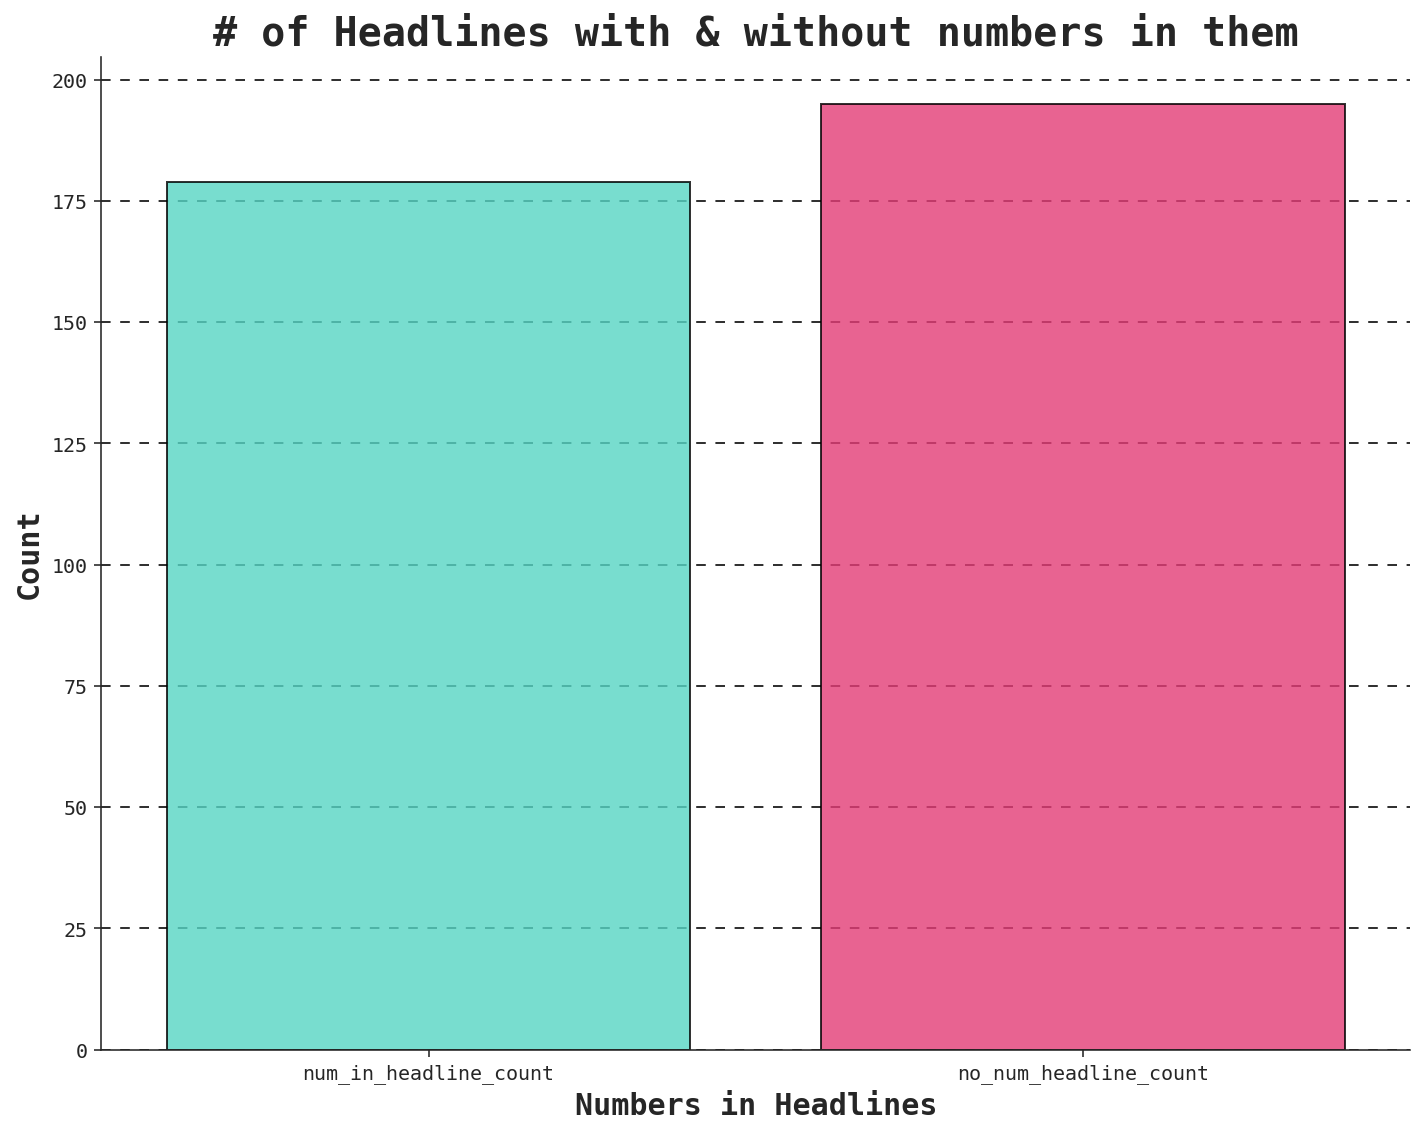

In [179]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=headline_numbers, ax=ax, alpha=0.8, zorder=2, palette=colors[-2:], edgecolor='black')
ax.set_title("# of Headlines with & without numbers in them", fontweight='bold', fontsize=20)
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
ax.set_xlabel("Numbers in Headlines", fontweight='bold', fontsize=15)
ax.set_ylabel("Count", fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show();

My guess would have been that there were more headlines with numbers in them than without, but as we can see the headlines are relatively balanced when it comes to titles containing numbers. Even more surprisingly, headlines without numbers have the slight edge over headlines that include digits.

For simplicity sake, let's cut down our data so that it just includes our title text and our text length. We can come back later and do some analysis on the `content` and `description` features of our original dataset, but for now it will be easier to just work with our necessary features.

In [180]:
title_df = data[['title', 'title_len']]
title_df.sample(5)

,title,title_len
79,your answers will predict which horror icon wi...,59
228,"71 brilliant details from ""community"" that sho...",114
257,jodie turner-smith opened up about her breastf...,128
113,13 tweets of awe and appreciation for kristen ...,83
363,"people are sharing popular ""disgusting"" things...",95


Remove stopwords from the titles and then we'll make a quick wordcloud to visualize popular words before we fully clean the text for other NLP analysis.

In [181]:
title_df['clean_title'] = title_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [182]:
title_df.sample(5)

,title,title_len,clean_title
126,"""the mentalist"" actor simon baker has reported...",125,"""the mentalist"" actor simon baker reportedly b..."
270,"""you"" season 3 just dropped and now everyone i...",74,"""you"" season 3 dropped everyone thirsting theo..."
363,"people are sharing popular ""disgusting"" things...",95,"people sharing popular ""disgusting"" things eve..."
225,"i'm sorry, but if you did literally any these ...",106,"i'm sorry, literally 40 things growing up, con..."
53,if you've heard 15/18 of these underrated gems...,78,heard 15/18 underrated gems bts true army!


In [183]:
clean_title_vals = title_df['clean_title'].values
print(clean_title_vals)

['35 affordable things make feel oh-so-fancy' 'would die "game thrones?"'
 'harry sally? john mclaine holly? quiz determine iconic holiday couple'
 '25 times harry styles went way make fans hella happy concerts 2021'
 'penn badgley weighed wild finale "you" season 3, could store character'
 'people included dogs weddings sweetest ways'
 '17 historical events people taught school, definitely know'
 "i'm begging freak guess generation based carb preferences"
 'adorable pet moments warm soul forever'
 'steve "blue\'s clues" joined tiktok, hilariously, first video millennial'
 '25 products disgusting-yet-satisfying photos hate love see'
 'data — parents named babies 2021'
 'shia labeouf almost cast "call name" instead armie hammer'
 '36 quick problem-solving products people simply time deal'
 "31 food photos horrific, they'll hurt eyes even they'd destroy stomach"
 'taylor swift pete davidson sang "three sad virgins" last night\'s "snl"'
 '24 products make say "i understand buzzfeed always

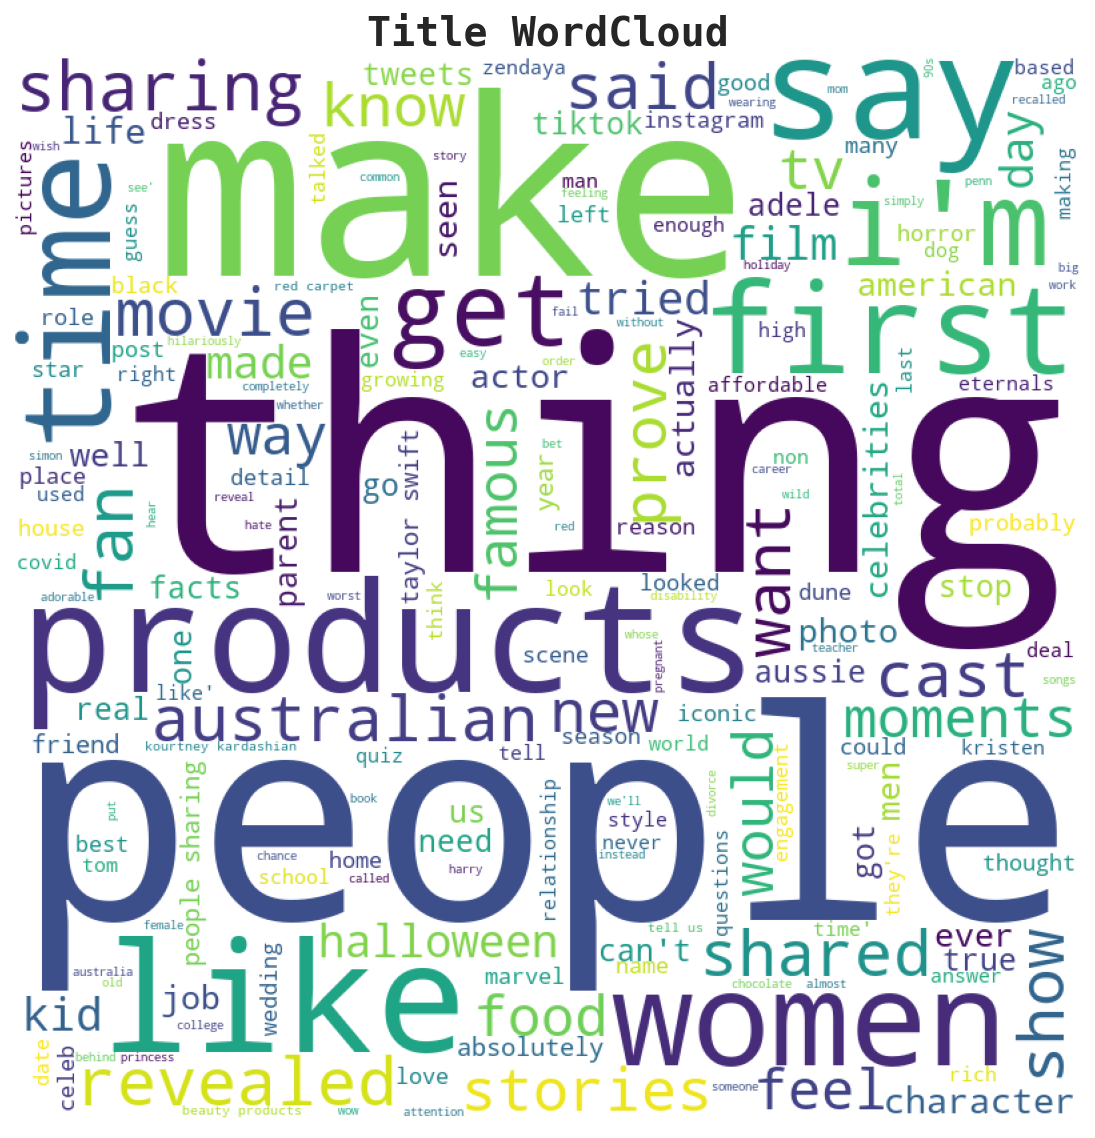

In [184]:
clean_title_vals = title_df['clean_title'].values

title_wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stop_words,
                      min_font_size=8).generate(str(clean_title_vals))

plt.figure(figsize=(10, 8))
plt.imshow(title_wordcloud)
plt.title("Title WordCloud", size=20, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show();

Basically the 3 most popular words that BuzzFeed uses in their headlines are "thing", "people", and "make". We don't need to know the context in which they use them just yet, but let's see if these 3 popular words translate into what their top n-gram combinations are...

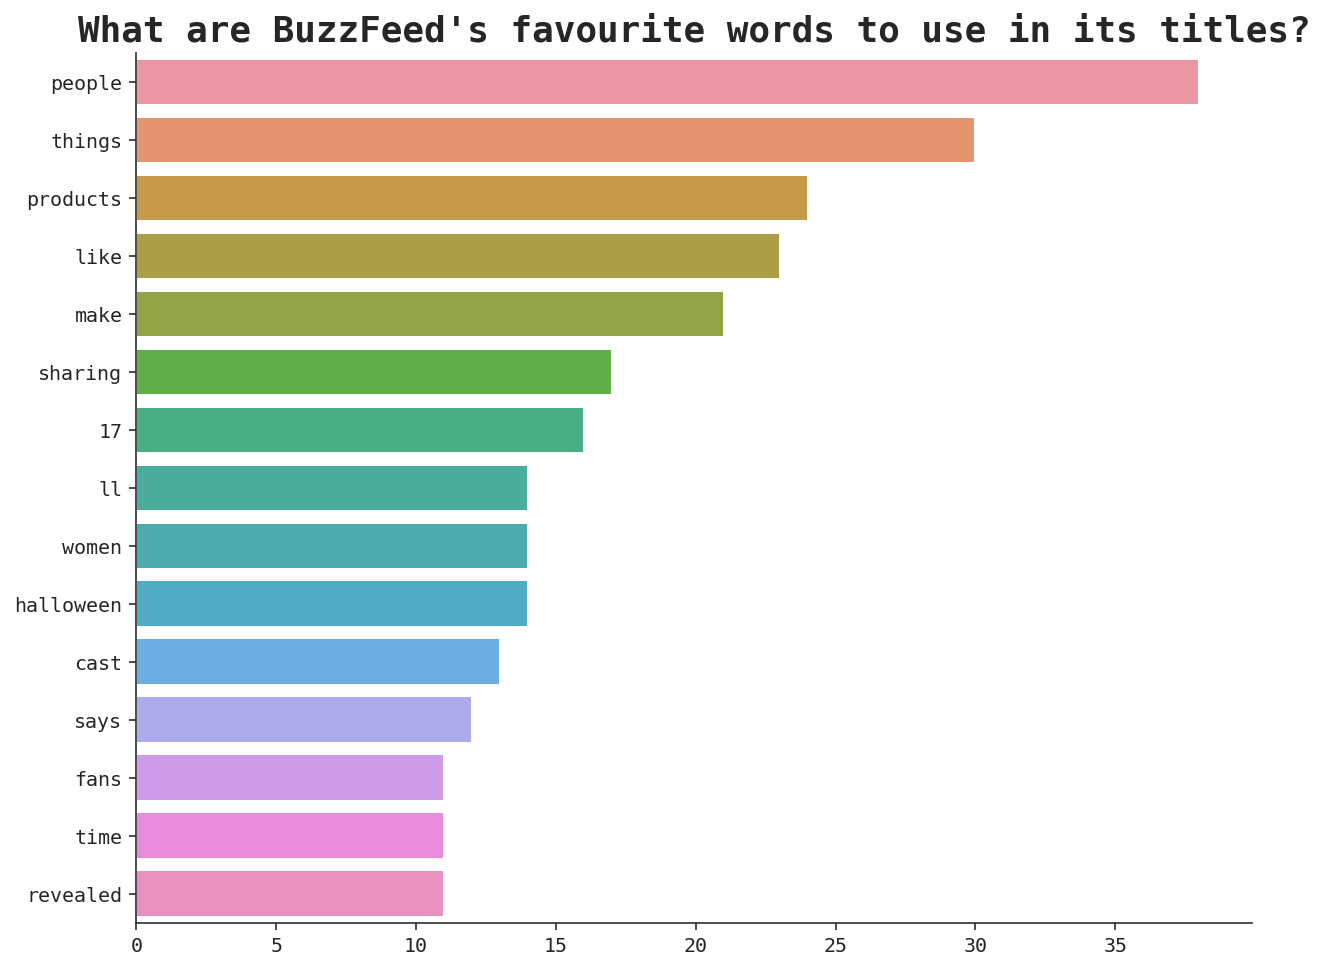

In [185]:
# n-gram visualizations

def get_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

top_n_unigrams = get_ngrams(title_df['clean_title'], 1)
x, y = map(list, zip(*top_n_unigrams))
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.title("What are BuzzFeed's favourite words to use in its titles?", size=18, fontweight='bold')
plt.show();

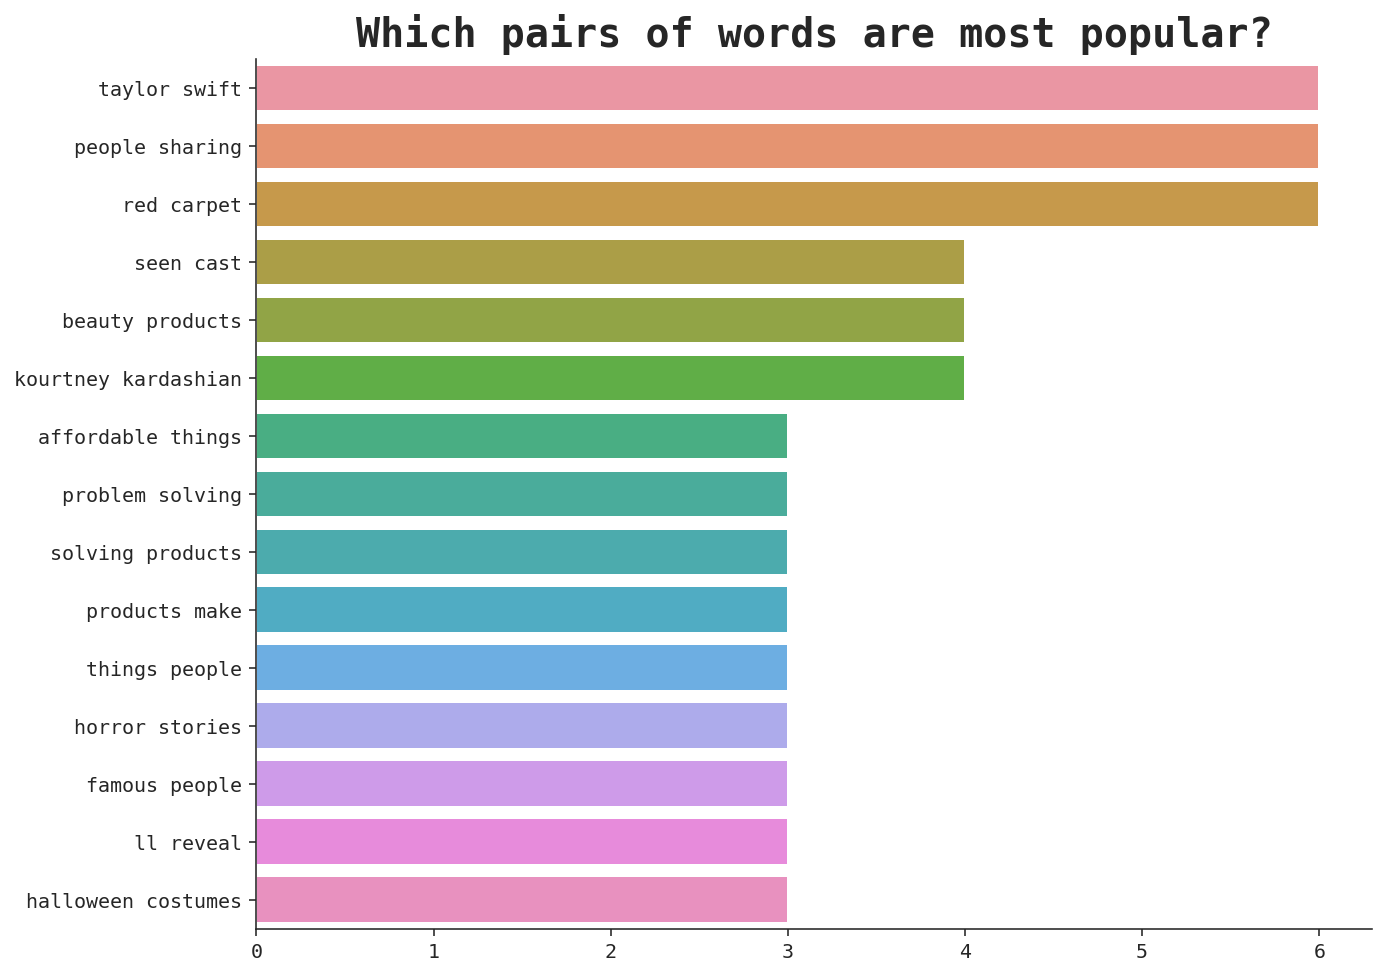

In [186]:
top_n_bigrams = get_ngrams(title_df['clean_title'], 2)
x, y = map(list, zip(*top_n_bigrams))
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.title("Which pairs of words are most popular?", size=20, fontweight='bold')
plt.show();

These pairings of words are a bit funny based off the time that they were collected in. We can obviously pick out which sort of topics BuzzFeed was covering at the time of scraping: Taylor Swift was re-releasing another album, there was obviously some sort of Kardashian drama going on, and it was around October that I collected the headlines.

We'll move on and start to do a bit of topic modeling with a cool library called `pyLDAvis`. First we'll process the text data a little bit more so the library functions can handle what we throw at it. We'll create a new function that will wrap all of our cleaning techniques into one:

In [187]:
def preprocess(df):
    corpus = []
    porter = PorterStemmer() # stemming
    for headline in title_df['clean_title']:
        words = [w for w in word_tokenize(headline) if (w not in stop_words)] # word tokenization & stopwords removal
        words = [porter.stem(w) for w in words if len(w)>2]
        words = [w.lower() for w in words] # a double check to lowercase everything
        # words = re.sub(r'[^\w\s]', '', ' '.join(words)) # remove punctuation
        
        corpus.append(words)
    return corpus

corpus = preprocess(title_df)

In [188]:
# create a Bag-of-Words model using gensim
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [189]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=3,
                                       id2word=dic,
                                       passes=10,
                                       workers=2,
                                       random_state=2021)
lda_model.show_topics()

[(0,
  '0.014*"thing" + 0.013*"make" + 0.008*"first" + 0.006*"australian" + 0.006*"look" + 0.006*"halloween" + 0.006*"stori" + 0.006*"share" + 0.005*"like" + 0.005*"kardashian"'),
 (1,
  '0.012*"peopl" + 0.010*"product" + 0.007*"thing" + 0.006*"like" + 0.006*"reveal" + 0.005*"time" + 0.005*"cast" + 0.005*"know" + 0.005*"film" + 0.005*"feel"'),
 (2,
  '0.010*"peopl" + 0.009*"share" + 0.008*"say" + 0.008*"get" + 0.004*"actor" + 0.004*"show" + 0.004*"friend" + 0.004*"celebr" + 0.004*"would" + 0.004*"tri"')]

In [190]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
pyLDAvis.display(vis)

/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
 

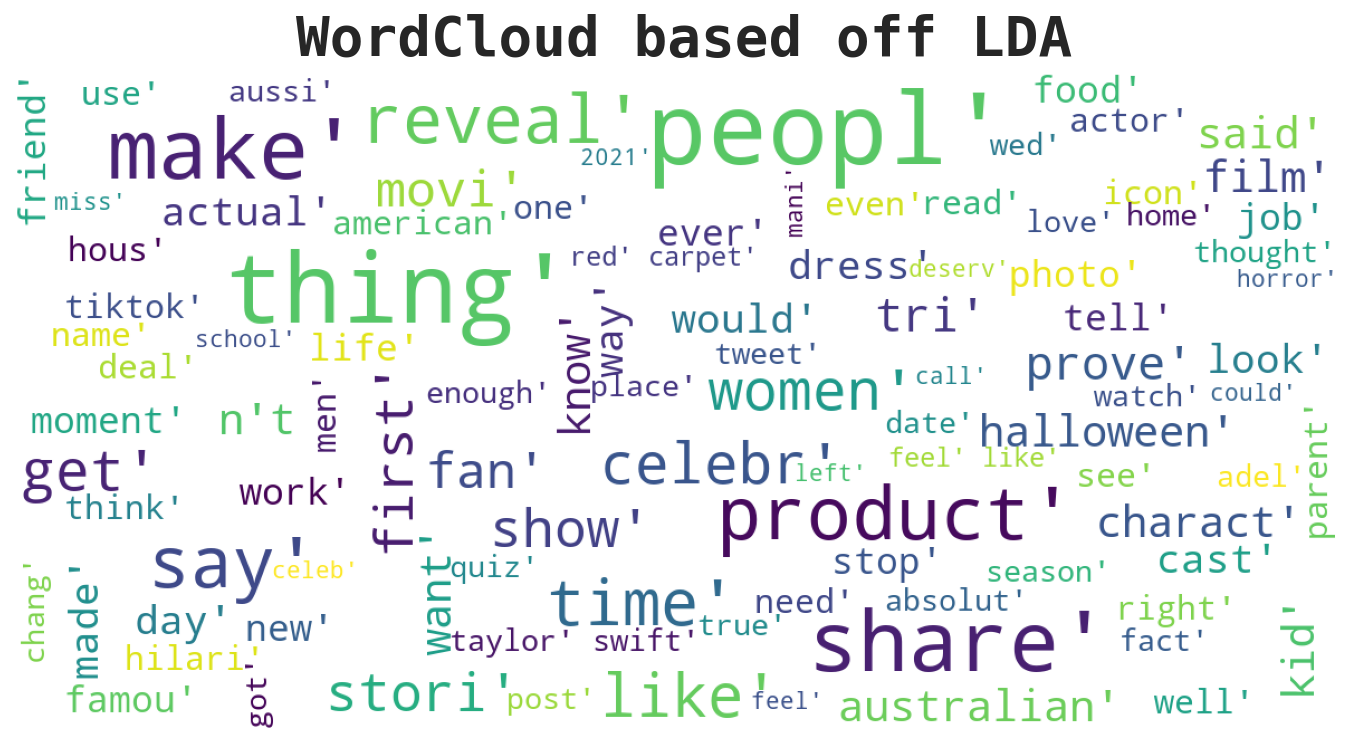

In [191]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=42
    )
    wordcloud = wordcloud.generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title("WordCloud based off LDA", size=28, fontweight='bold')
    plt.show();
    
show_wordcloud(corpus)

Moving on to use the TextBlob library to calculate the polarity and sentiment of the headlines.

In [192]:
from textblob import TextBlob

In [193]:
def polarity(text):
    # calculating polarity scores of our headlines
    # will give a score between -1.0 and 1.0
    return TextBlob(text).sentiment.polarity

title_df['polarity_score'] = title_df['title'].apply(lambda x: polarity(x))

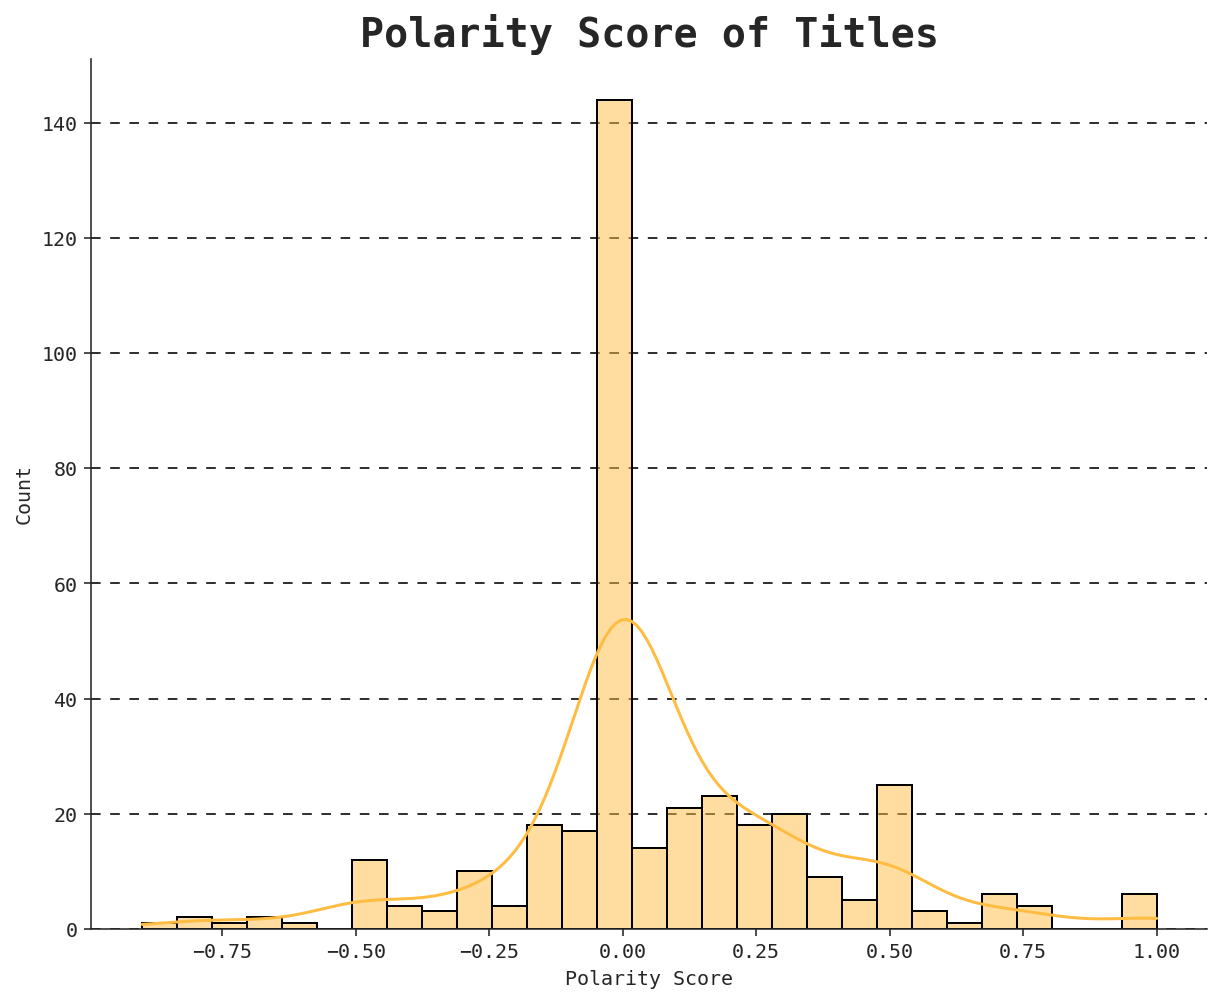

In [194]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(title_df.polarity_score, kde=True, color=colors[2], edgecolor='black', ax=ax)
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
ax.set_title("Polarity Score of Titles", size=20, fontweight='bold')
ax.set_xlabel("Polarity Score")
plt.show();

In [195]:
title_df['polarity_score'].describe()

count    374.000000
mean       0.081017
std        0.294152
min       -0.900000
25%        0.000000
50%        0.000000
75%        0.241518
max        1.000000
Name: polarity_score, dtype: float64

We can see that our mean polarity score is around 0.08 which is a very low score, meaning that our headlines, on average, are quite neutral and maybe even slightly more positive in their sentiment. BuzzFeed isn't generally a news outlet that gets too political, but we can also note that my period of collection of the headlines wasn't any significant point in time so there shouldn't be many polarizing topics unless BuzzFeed editors are feeling frisky. We'll have a better conclusion once we calculate the sentiments and visualize them.

So we've got polarity scores to quantitatively show what our headlines are like, but let's classify those scores as either positive, negative or neutral sentiment. We'll do this by creating a function that specifies a threshold, and if the scores are above, below, or equal to the threshold then we bin them into their corresponding category.

In [196]:
def sentiment(x):
    if x < 0:
        return 'negative'
    elif x == 0:
        return 'neutral'
    else:
        return 'positive'
    
title_df['sentiment'] = title_df['polarity_score'].apply(lambda x: sentiment(x))

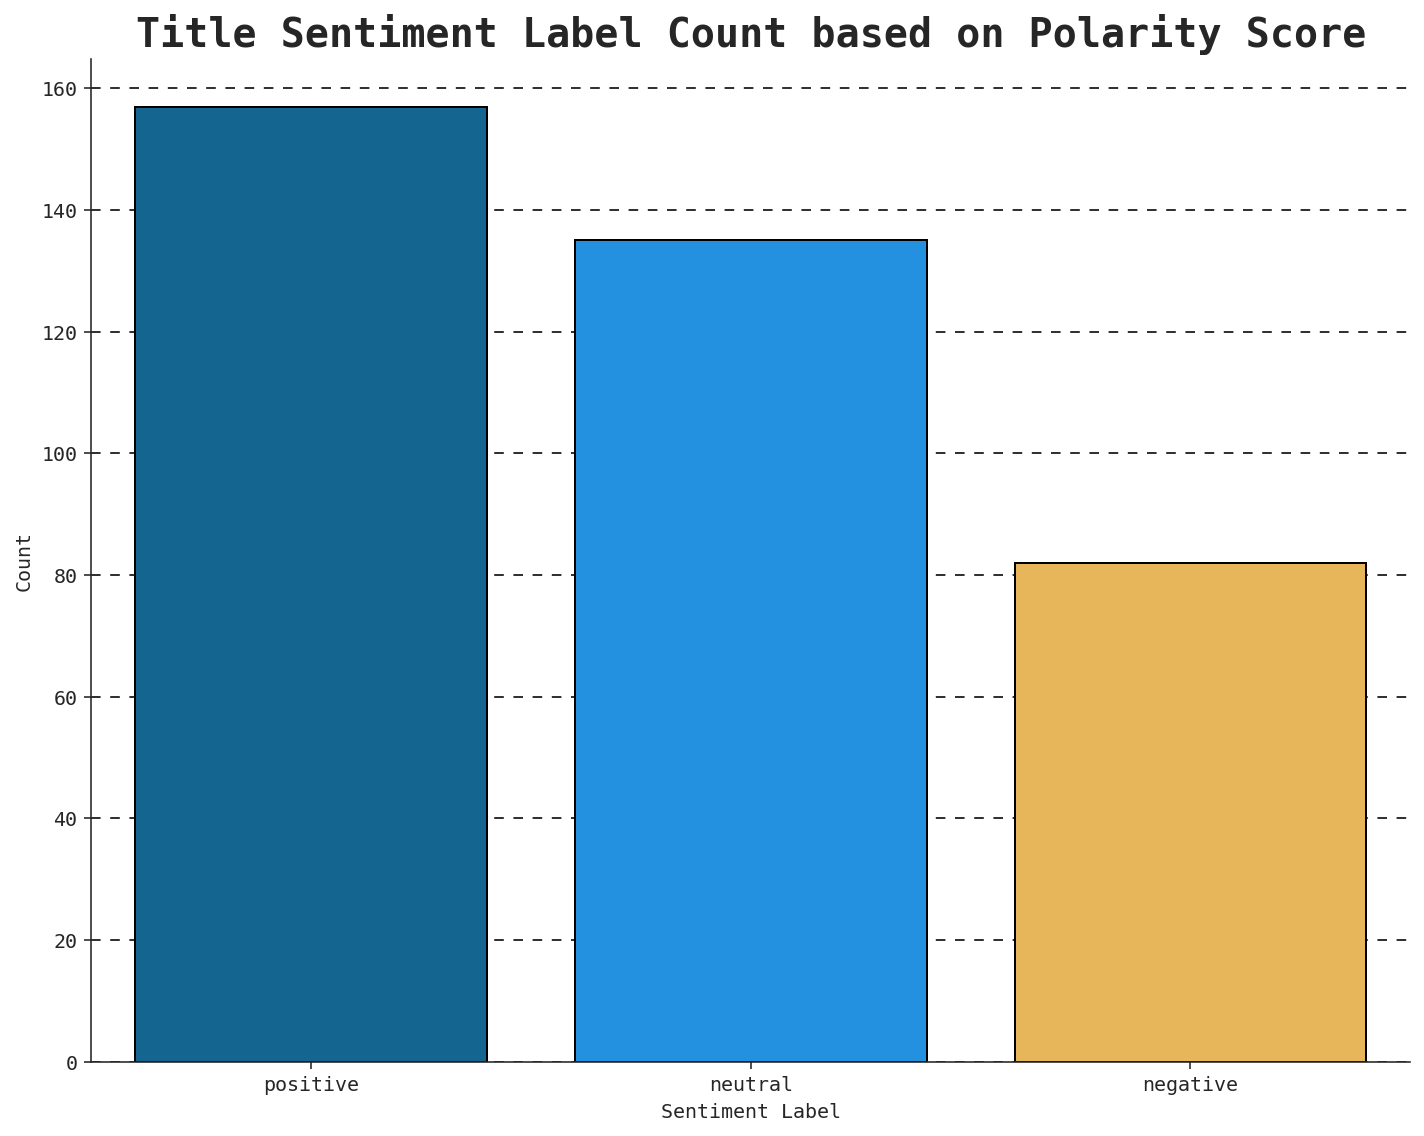

In [197]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(title_df.sentiment.value_counts().index,
            title_df.sentiment.value_counts(), edgecolor='black')
ax.set_title("Title Sentiment Label Count based on Polarity Score", size=20, fontweight='bold')
ax.set_xlabel("Sentiment Label")
ax.set_ylabel("Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.tight_layout()
plt.show();

In [198]:
pct_sent = round((title_df.sentiment.value_counts() / (len(title_df)))*100, 2)
print(pct_sent)

positive    41.98
neutral     36.10
negative    21.93
Name: sentiment, dtype: float64


Let's take a look at a few headlines from each sentiment category...

In [199]:
pos_headlines = title_df[title_df['sentiment'] == 'positive']['title']
print(pos_headlines.sample(3).tolist())

['15 celebrity couples that were so unexpected they still keep me up at night', 'dwayne "the rock" johnson wants to be daniel craig\'s james bond successor, and i hope producers are seeing this right now', "an endless scooby-doo impression, a detour to an ex's house, and 23 other ways men absolutely ruined first dates"]


In [200]:
neu_headlines = title_df[title_df['sentiment'] == 'neutral']['title']
print(neu_headlines.sample(3).tolist())

['13 celebrities who made it big and then bought their parents a brand-new house', 'order a school lunch to find out how old you are mentally', '24 products that\'ll make you say "i understand why buzzfeed always writes about these"']


In [201]:
neg_headlines = title_df[title_df['sentiment'] == 'negative']['title']
print(neg_headlines.sample(3).tolist())

['34 hysterical tweets from this month so far that you just need to see for yourself', '16 books by black authors that are total must reads', 'people are sharing popular "disgusting" things everyone should stop doing, and points were made']


We see some interesting headlines when we print out the results. Some even don't make sense being in the category that they're in. This could be due to the fact that some sentiment analysis techniques/libraries aren't great at detecting negative sentiments. One library that works pretty well at detecting negative sentiments is the VADER library. We can import it via `nltk` and work from there.

In [202]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def vader_score(sent):
    ss = sia.polarity_scores(sent)
    
    return np.argmax(list(ss.values())[::-1])

title_df['polarity'] = title_df['title'].apply(lambda x: vader_score(x))
polarity = title_df['polarity'].replace({0:'neg', 2:'neu', 3:'pos'})

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


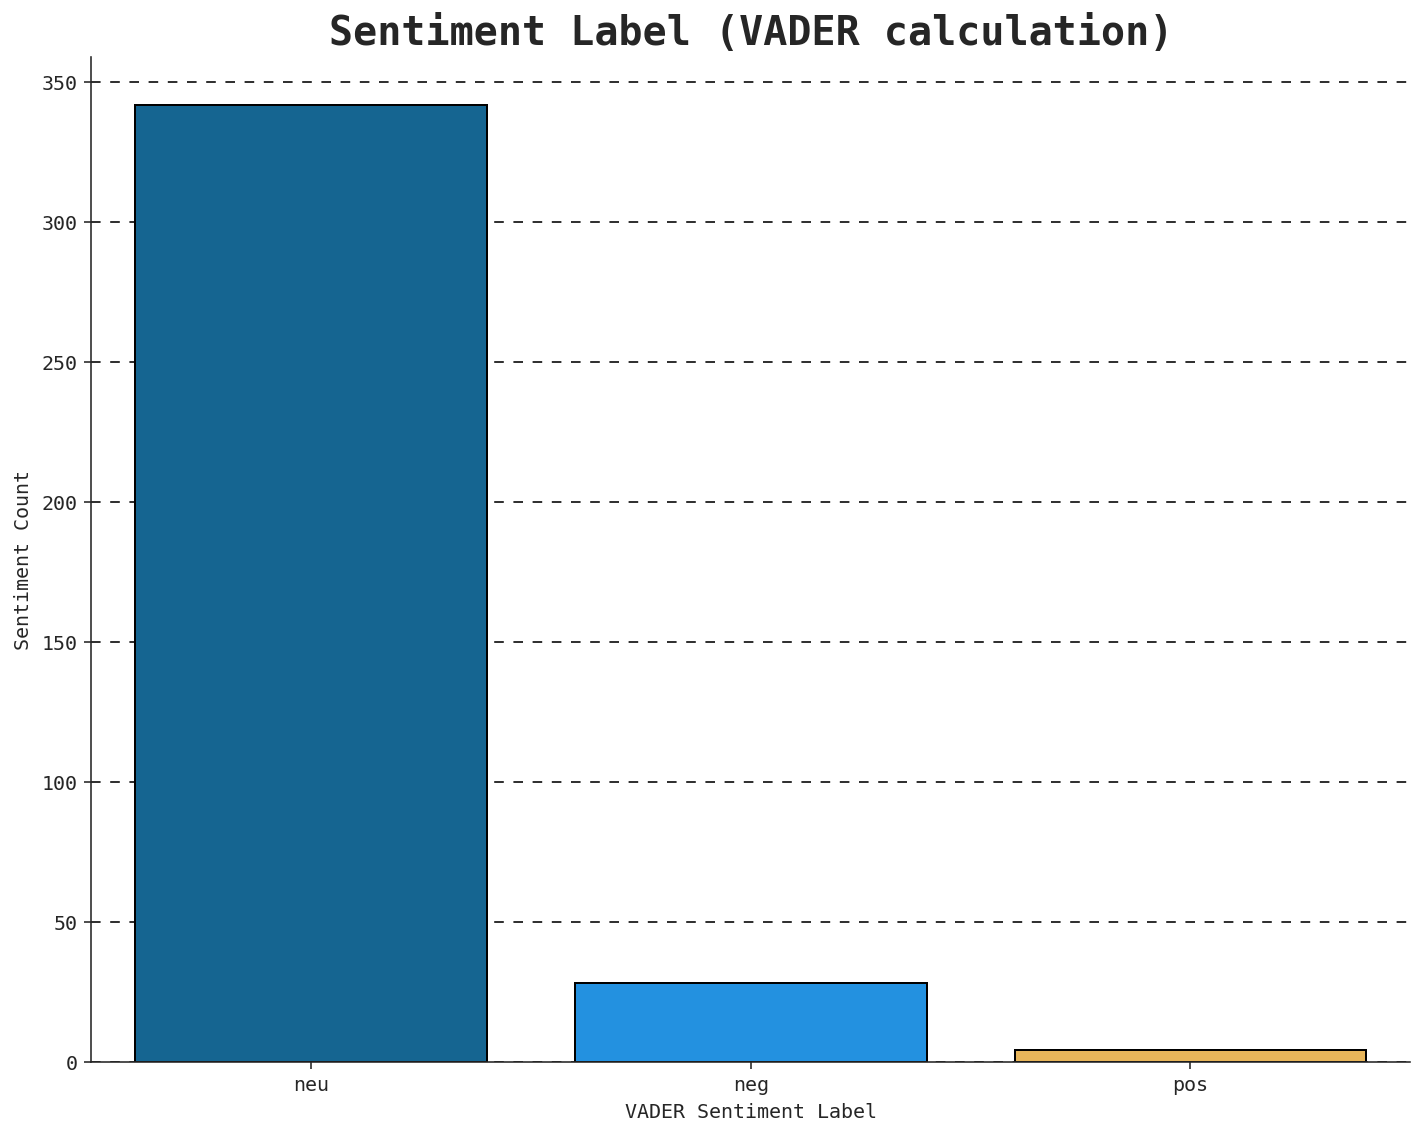

In [203]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(polarity.value_counts().index,
            polarity.value_counts(), edgecolor='black')
ax.set_title("Sentiment Label (VADER calculation)", size=20, fontweight='bold')
ax.set_xlabel("VADER Sentiment Label")
ax.set_ylabel("Sentiment Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.tight_layout()
plt.show();

Wow! That's a massive shift in sentiments from our first run at it. Things that were probably classified as "borderline" negative or positive sentiments have now most likely shifted to neutral. We can probably guess now the titles that are in the negative & positive sentiment classes have scores that show they're close to the far ends of either spectrum.

In [204]:
title_df['polarity'].value_counts()

2    342
0     28
3      4
Name: polarity, dtype: int64

In [205]:
title_df['polarity'].describe()

count    374.000000
mean       1.860963
std        0.540008
min        0.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: polarity, dtype: float64

In [206]:
def vader_sentiment(score):
    emotion = ""
    if score == 2.0:
        return "neutral"
    elif score == 3.0:
        return "positive"
    else:
        return "negative"

In [207]:
title_df['vader_sentiment'] = title_df['polarity'].apply(lambda x: vader_sentiment(x))
title_df['vader_sentiment'].value_counts()

neutral     342
negative     28
positive      4
Name: vader_sentiment, dtype: int64

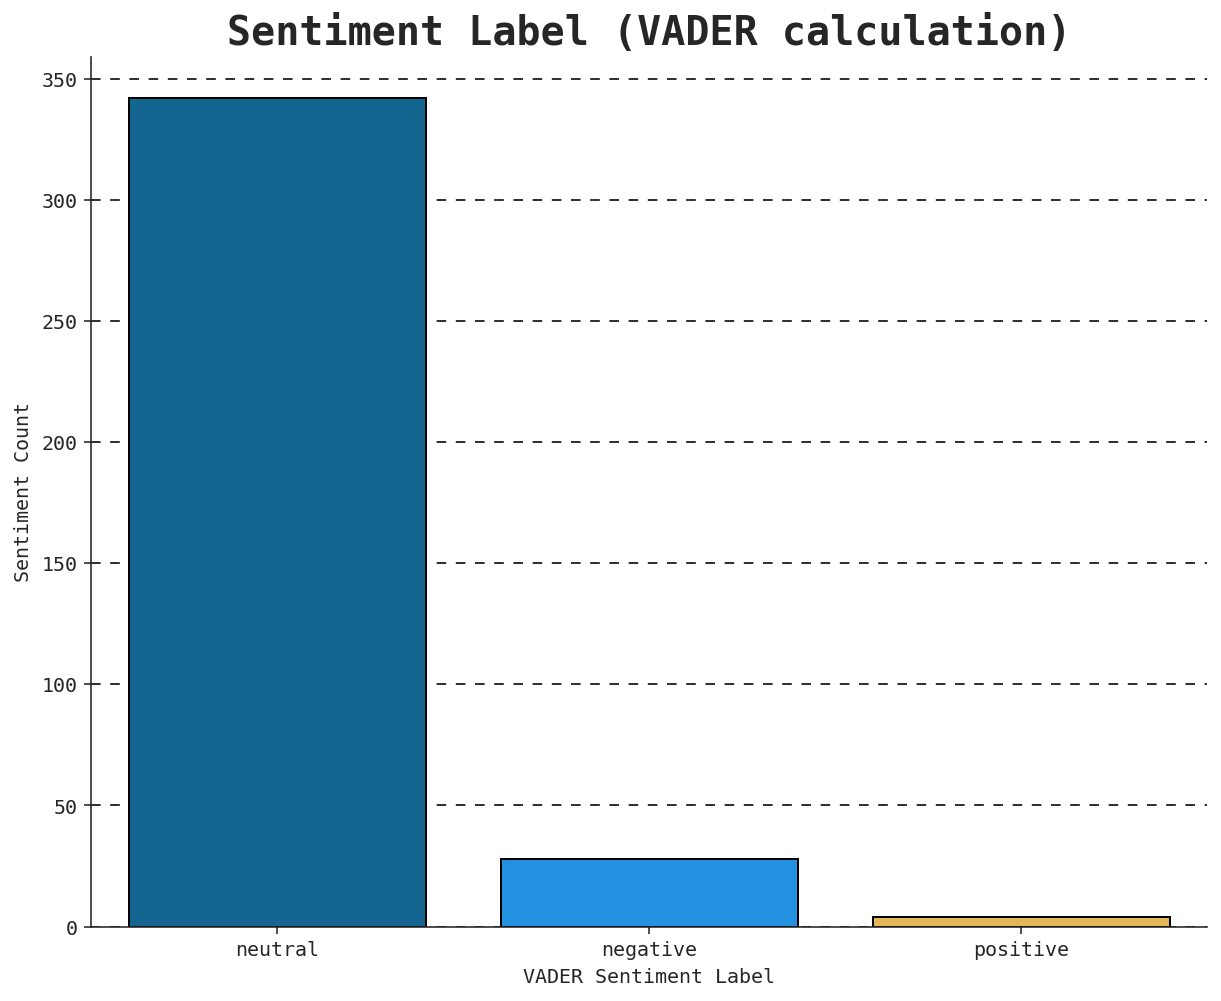

In [208]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(title_df['vader_sentiment'].value_counts().index,
            title_df['vader_sentiment'].value_counts(), edgecolor='black')
ax.set_title("Sentiment Label (VADER calculation)", size=20, fontweight='bold')
ax.set_xlabel("VADER Sentiment Label")
ax.set_ylabel("Sentiment Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.show();

Visualize NER with SpaCy

In [209]:
# hide
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 2.5 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [216]:
import spacy
from spacy import displacy
# from IPython.core.display import display, HTML

nlp = spacy.load('en_core_web_sm')

for _ in range(4):
    rand_title = np.random.randint(0, 381)
    text = title_df['title'][rand_title]
    doc = nlp(text)
    displacy.render(doc, style='ent')

I've run the above code multiple times and it seems like the visualizer doesn't pick up on some basic names. For now we'll move along. What we can do that might be useful is to apply NER on our headlines and then store the entity types.

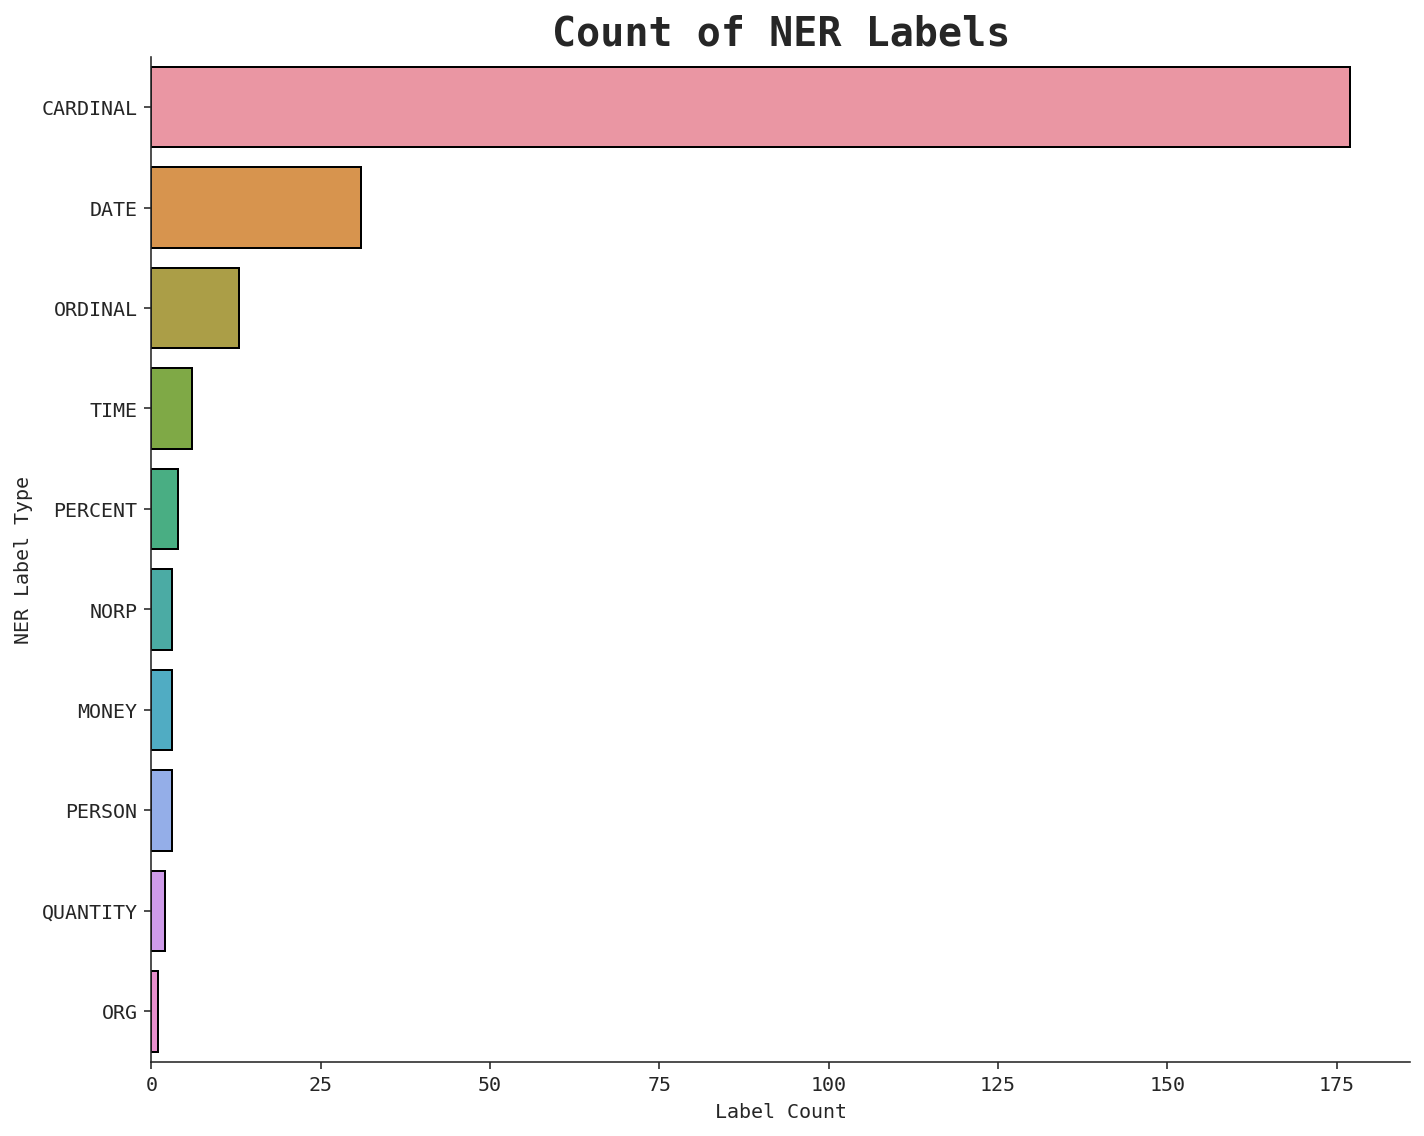

In [217]:
from collections import Counter

def ner_types(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = title_df['title'].apply(lambda x: ner_types(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

fig, ax = plt.subplots(figsize=(10, 8))
x, y = map(list, zip(*count))
sns.barplot(x=y, y=x, edgecolor='black')
ax.set_title("Count of NER Labels", size=20, fontweight='bold')
ax.set_xlabel("Label Count")
ax.set_ylabel("NER Label Type")
plt.tight_layout()
plt.show();

After the NER graph, I think it's clear even from our own observations that BuzzFeed loves numbers in their headlines.

In [218]:
title_df.head()

,title,title_len,clean_title,polarity_score,sentiment,polarity,vader_sentiment
0,35 affordable things that'll make you feel oh-...,54,35 affordable things make feel oh-so-fancy,0.0,neutral,2,neutral
1,"how would you die on ""game of thrones?""",39,"would die ""game thrones?""",-0.4,negative,2,neutral
2,harry and sally? john mclaine and holly? this ...,101,harry sally? john mclaine holly? quiz determin...,0.5,positive,2,neutral
3,25 times harry styles went out of his way to m...,98,25 times harry styles went way make fans hella...,0.8,positive,2,neutral
4,penn badgley weighed in on the wild finale of ...,106,"penn badgley weighed wild finale ""you"" season ...",0.1,positive,2,neutral


Let's create a stripped down dataset for our deep learning models to come...

In [219]:
model_df = title_df[['clean_title']]
model_df.to_csv('../data/clean_titles.csv', index=False)